In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.util import ngrams
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data = pd.read_csv('sentences.csv')

# 1. There is a need to check for any NaN values across all columns

In [ ]:
nan_counts = data.isna().sum()
print(nan_counts)

id                    0
document_id           0
sentence_index        0
text                  0
corrected            29
status            28951
dtype: int64


So, there are 29 empty rows in the `corrected` column. Let's show them, save their indices and remove them from the dataset.

In [ ]:
data_with_empty = data[data['corrected'].isna()]
data_with_empty

,id,document_id,sentence_index,text,corrected,status
178,17017,17,17,"О здравоохранении в Советском Союзе мы узнали,...",NaN,needs correction
5713,1268008,1268,8,"В реальности, только 59.",NaN,NaN
8607,5671023,5671,23,США не может платить за этих людей.,NaN,NaN
13991,8739010,8739,10,Они оседлают раньше своего конька.,NaN,needs correction
13995,8739014,8739,14,"Она думала, Ива это <нрзб> долго.",NaN,NaN
14115,8770002,8770,2,Сегодна я иду в аэропорту а небо солнечный.,NaN,needs correction
15133,9164025,9164,25,"Его фамилия - Фрега, его имя - Петро.",NaN,needs correction
18417,9548003,9548,3,Ничего Ничего!,NaN,NaN
19303,9748016,9748,16,"Да, если логическии интерпретации, а нет если ...",NaN,NaN
19372,9754003,9754,3,Над мячом недалеко от луны.,NaN,NaN


In [ ]:
data_with_empty.to_csv('empty.csv')

In [ ]:
data = data[~data['corrected'].isna()]

# 2. Saving indices of sentences having status "needs correction"

In [ ]:
ids = []
for id, row in data.iterrows():
    if row['status'] == 'needs correction':
        ids.append(id)
len(ids)

2549

There are not so many of such sentences so it is better to remove them from the dataset as well.

In [ ]:
data = data[data['status'] != 'needs correction']

# 3. Detecting the length of sentences in the dataset.

In [ ]:
from nltk import word_tokenize

def calc_token_len(example):
    return len(word_tokenize(example))

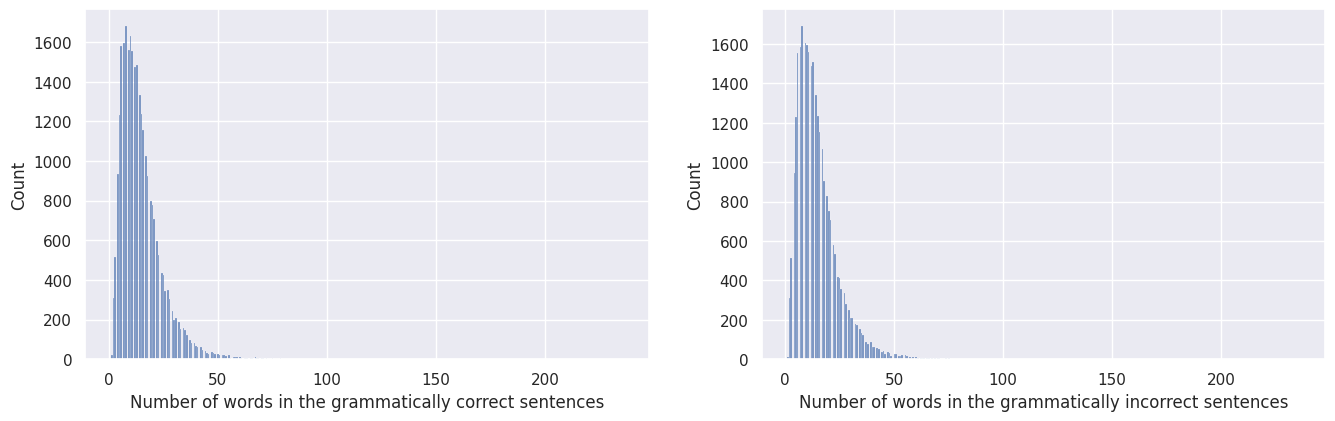

In [ ]:
len_1 = [calc_token_len(data['corrected'].iloc[i]) for i in range(len(data['corrected'])) ]
len_2 = [calc_token_len(data['text'].iloc[i]) for i in range(len(data['text'])) ]

sns.set_theme()
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
ax = sns.histplot(data=len_1)
ax.set_xlabel('Number of words in the grammatically correct sentences')

plt.subplot(2, 2, 2)
ax = sns.histplot(data=len_2)
ax.set_xlabel('Number of words in the grammatically incorrect sentences')
plt.show()

Seems like there are items containing enormously long sequences. It is not Ok.

Here is an example of a sentence with maximum length:

In [ ]:
data['text'].iloc[np.argmax(len_2)]

'Как дела?Во время эпидемии вы и ваша семья были здоровы?Я скучаю по тебе, когда ты дома.Я живу в доме уже много месяцев.Как там эпидемия в россии?Мне хорошо в китае.Семьи в китае и наши друзья тоже в безопасности.Мы учимся онлайн, и нам нельзя выходить из дома.Я выполняю все требования.Надеюсь, ты сможешь защитить себя.Как вы живете в россии?Вы в безопасности?Хорошая новость в Том, что через месяц мы будем в школе.Потому что состояние китая находится под хорошим контролем.Все эти месяцы мне было скучно, и я всегда хотела бросить занятия по интернету.Потому что мне всегда трудно сосредоточиться.Мне нужно делать свою работу по дому, готовить самому.Иногда я забываю поесть.Я всегда выбираю что-то попроще и попроще.Потому что блюда, которые я хочу есть, слишком сложны для меня.В общежитии я могу заниматься спортом, смотреть фильмы и делать что-то вручную.Когда я училась в интернете, я начала очень непривычно к новой модели преподавания, и мне было трудно приспособиться к различным методам

There are several sentences in one entity, which means that they need to be split and placed on multiple rows.

# 4. For entries containing multiple sentences, we will split them into separate rows. This often involves detecting sentence boundaries.

In [ ]:
data.shape

(28941, 6)

If after tokenization the number of incorrect and correct sentences in a row is not the same, I skip this case, though it is not the best option.

In [ ]:
# split text into sentences using sent_tokenize
from nltk import sent_tokenize

def replacement(text):
    text = text.replace('.', '. ')
    text = text.replace('?', '? ')
    text = text.replace('!', '! ')
    return text

def split_large(texts1, texts2):
    arr1, arr2 = [], []
    for i in range(len(texts1)):
        new1 = sent_tokenize(replacement(texts1[i]))
        new2 = sent_tokenize(replacement(texts2[i]))
        if len(new1) == len(new2):
            for j in range(len(new1)):
                arr1.append(new1[j])
                arr2.append(new2[j])
    return arr1, arr2

# recreate the DataFrame with split sentences
not_correct = data['text'].to_list()
correct = data['corrected'].to_list()
new_not_corr, new_corr = split_large(not_correct, correct)
df = pd.DataFrame({'text': new_not_corr, 'corrected': new_corr})

In [ ]:
df.head()

,text,corrected
0,Загрязнение тяжелыми металлами Дальнегорского ...,Загрязнение тяжелыми металлами Дальнегорского ...
1,Одной из самых главных экологических проблем н...,Одной из самых главных экологических проблем н...
2,Эта проблема особеннo характерна для тех местн...,Эта проблема особеннo характерна для тех местн...
3,Рудная Пристань.,Рудная Пристань.
4,Согласно проведенным исследованиям Тихоокеанск...,Согласно проведенным исследованиям Тихоокеанск...


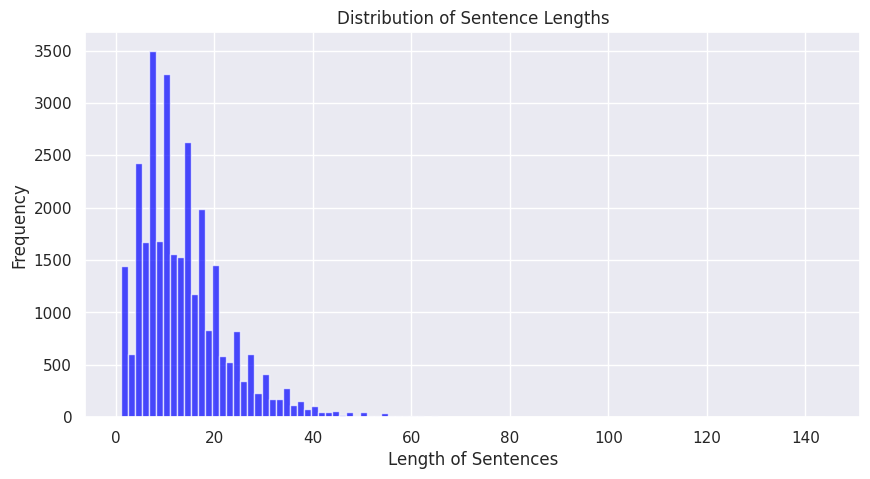

In [ ]:
# sentence length distribution after changes, it's Ok to look at only one column cause their distribution is almost equal
df['sentence_length'] = df['text'].apply(calc_token_len)
plt.figure(figsize=(10, 5))
plt.hist(df['sentence_length'], bins=100, alpha=0.7, color='blue')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.isna().sum()

text               0
corrected          0
sentence_length    0
dtype: int64

# 5. Let's also examine the linguistic features, the complexity of sentences, co-occurrences of words, and potential data inconsistencies or errors.

### 5.1. Lexical diversity

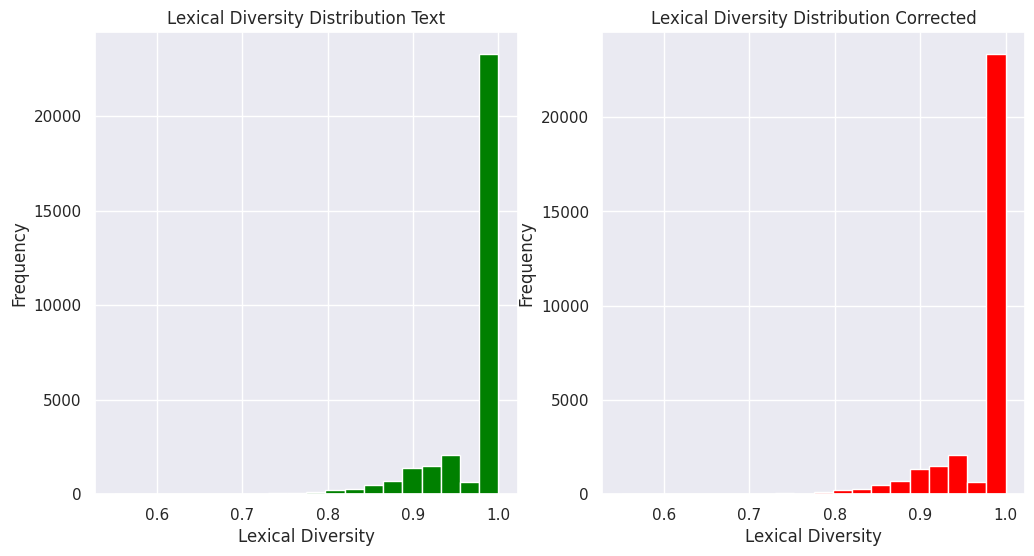

In [ ]:
df['lexical_diversity_text'] = df['text'].apply(lambda x: len(set(x.split())) / len(x.split()) if x.split() else 0)
df['lexical_diversity_corrected'] = df['corrected'].apply(lambda x: len(set(x.split())) / len(x.split()) if x.split() else 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['lexical_diversity_text'], bins=20, color='green')
plt.title('Lexical Diversity Distribution Text')
plt.xlabel('Lexical Diversity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['lexical_diversity_corrected'], bins=20, color='red')
plt.title('Lexical Diversity Distribution Corrected')
plt.xlabel('Lexical Diversity')
plt.ylabel('Frequency')
plt.show()

### 5.2. Part-of-speech tagging analysis

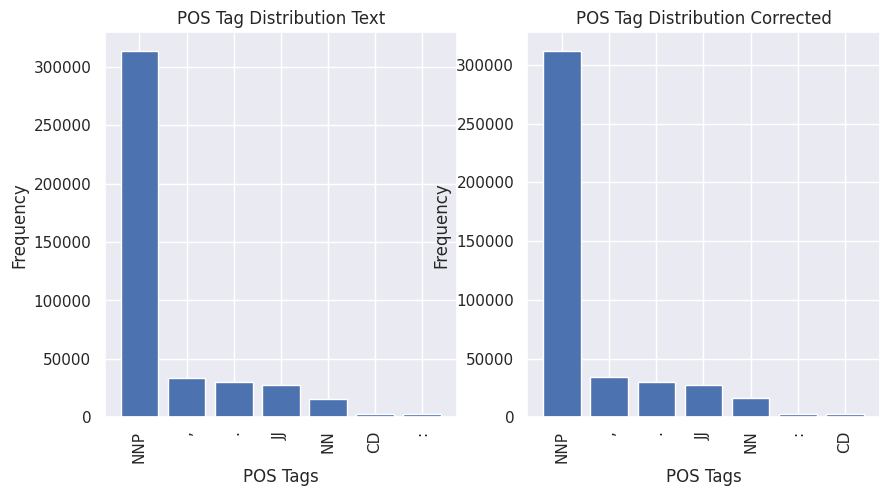

In [ ]:
df['pos_tags_text'] = df['text'].apply(lambda x: pos_tag(nltk.word_tokenize(x)))
pos_counts_1 = Counter([pos for sublist in df['pos_tags_text'].tolist() for _, pos in sublist])

df['pos_tags_corrected'] = df['corrected'].apply(lambda x: pos_tag(nltk.word_tokenize(x)))
pos_counts_2 = Counter([pos for sublist in df['pos_tags_corrected'].tolist() for _, pos in sublist])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
pos_names_1, pos_values_1 = zip(*pos_counts_1.most_common(7))
plt.bar(pos_names_1, pos_values_1)
plt.title('POS Tag Distribution Text')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
pos_names_2, pos_values_2 = zip(*pos_counts_2.most_common(7))
plt.bar(pos_names_2, pos_values_2)
plt.title('POS Tag Distribution Corrected')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

+ CD	cardinal digit
+ DT	determiner
+ EX	existential there
+ JJ	This NLTK POS Tag is an adjective (large)
+ NN	noun, singular (cat, tree)
+ NNP	proper noun, singular (sarah)

### 5.3. Co-occurrence and N-gram analysis

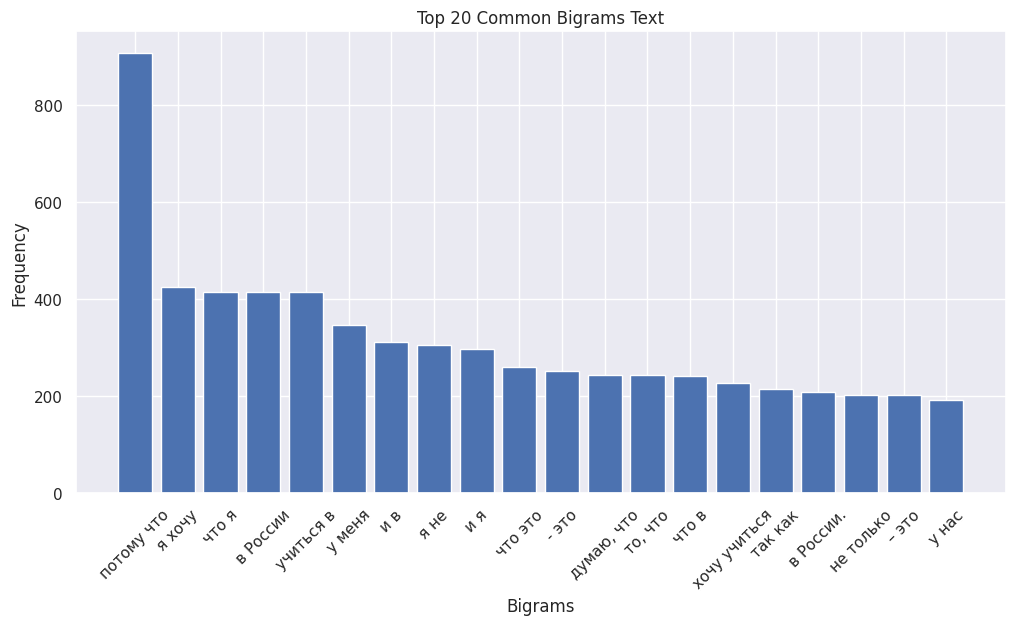

In [ ]:
bigram_counts = Counter([gram for sublist in df['text'].tolist() for gram in ngrams(sublist.split(), 2)])
common_bigrams = bigram_counts.most_common(20)
bigram_words, bigram_freqs = zip(*common_bigrams)
plt.figure(figsize=(12, 6))
plt.bar([' '.join(gram) for gram in bigram_words], bigram_freqs)
plt.title('Top 20 Common Bigrams Text')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

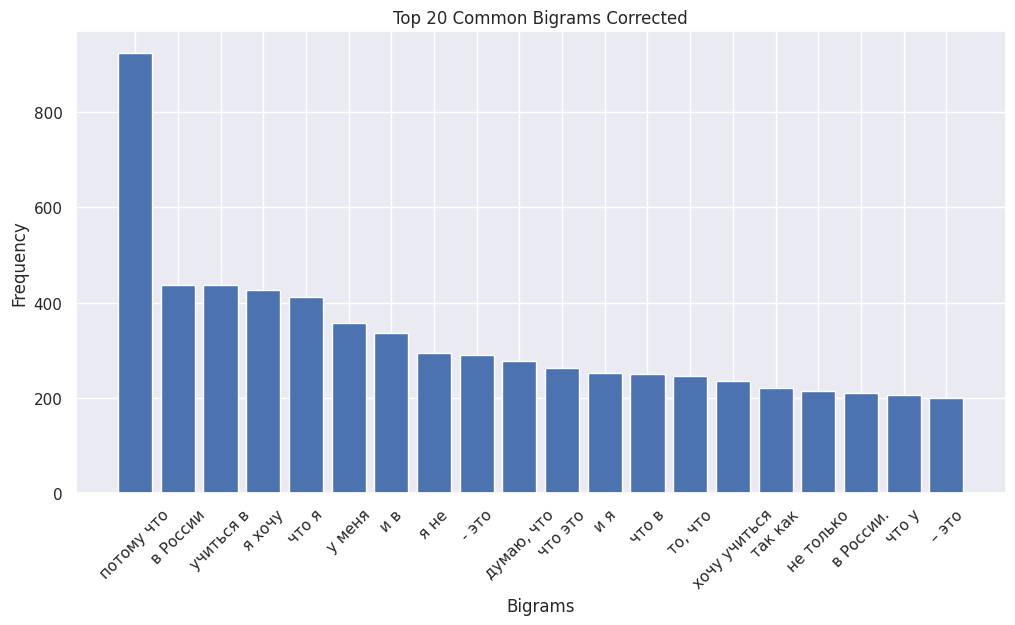

In [ ]:
bigram_counts = Counter([gram for sublist in df['corrected'].tolist() for gram in ngrams(sublist.split(), 2)])
common_bigrams = bigram_counts.most_common(20)
bigram_words, bigram_freqs = zip(*common_bigrams)
plt.figure(figsize=(12, 6))
plt.bar([' '.join(gram) for gram in bigram_words], bigram_freqs)
plt.title('Top 20 Common Bigrams Corrected')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

### 5.4. Anomaly detection

In [ ]:
Q1 = df['sentence_length'].quantile(0.25)
Q3 = df['sentence_length'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['sentence_length'] < (Q1 - 1.5 * IQR)) | (df['sentence_length'] > (Q3 + 1.5 * IQR))]

outliers.to_csv('outliers.csv')

In [ ]:
max(df['sentence_length'])

144